### 2024/01/22 コサイン類似度の時系列データを描画する

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [1]:
box_abct_nopt = pd.read_pickle('../temp/20240117_box_abct_nopt_rmoverlapcoord.pkl')

In [3]:
# COSSIM_PLOT_COLOR = '#47C96D'
# LINE_WIDTH = 1
# def generate_cossim_plot(df):
#     plt.rcParams['font.family'] = 'MS Gothic'
#     FIG_SIZE = (10, 5)
#     for drawing_id, cos_sim, stroke_id in zip(df['drawing_id'], df['cos_sim'], df['stroke_id']):
#         fig, ax = plt.subplots(figsize=(FIG_SIZE[0],FIG_SIZE[1]))
#         ax.set_ylim(-1.2, 1.2)
#         ax.set_xlabel('線形補完後の座標の順番 [番目]')
#         ax.set_ylabel('コサイン類似度')
#         ax.grid(True, alpha=0.2)
#         title = f'cossim_{drawing_id}_{stroke_id}'
#         ax.set_title(title)
#         ax.plot(range(941), cos_sim, color=COSSIM_PLOT_COLOR, linewidth=LINE_WIDTH, alpha=1)
#         plt.savefig(f'../temp/test/{title}.png')
        
#         print(drawing_id, ' | ', stroke_id)
    
#     return

# generate_cossim_plot(box_abct_nopt[23500:])

##### ▶AEに入力してみる

In [12]:
strt = box_abct_nopt.query('shape_int == 1')
curv = box_abct_nopt.query('shape_int == 2')
comp = box_abct_nopt.query('shape_int == 3')
hatc = box_abct_nopt.query('shape_int == 4')

train_data = strt.copy()
train_nparray = np.array([np.array(nparr) for nparr in train_data['cos_sim'].to_numpy()])

test_data = box_abct_nopt.copy()
test_nparray = np.array([np.array(nparr) for nparr in test_data['cos_sim'].to_numpy()])

In [16]:
INPUT_SIZE = 941

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="relu"),
      layers.Dense(INPUT_SIZE, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [17]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [18]:
history = autoencoder.fit(
    train_nparray,
    train_nparray,
    epochs=20,
    batch_size=512,
    validation_data=(test_nparray, test_nparray),
    shuffle=True)

Epoch 1/20
24/24 [==============================] - 2s 43ms/step - loss: 0.5261 - val_loss: 0.4248
Epoch 2/20
24/24 [==============================] - 1s 30ms/step - loss: 0.4193 - val_loss: 0.4128
Epoch 3/20
24/24 [==============================] - 1s 28ms/step - loss: 0.4059 - val_loss: 0.4173
Epoch 4/20
24/24 [==============================] - 1s 27ms/step - loss: 0.4059 - val_loss: 0.4096
Epoch 5/20
24/24 [==============================] - 1s 27ms/step - loss: 0.3986 - val_loss: 0.3975
Epoch 6/20
24/24 [==============================] - 1s 29ms/step - loss: 0.3969 - val_loss: 0.3953
Epoch 7/20
24/24 [==============================] - 1s 31ms/step - loss: 0.3959 - val_loss: 0.3967
Epoch 8/20
24/24 [==============================] - 1s 28ms/step - loss: 0.3943 - val_loss: 0.3980
Epoch 9/20
24/24 [==============================] - 1s 29ms/step - loss: 0.3948 - val_loss: 0.3925
Epoch 10/20
24/24 [==============================] - 1s 28ms/step - loss: 0.3934 - val_loss: 0.3934
Epoch 11/

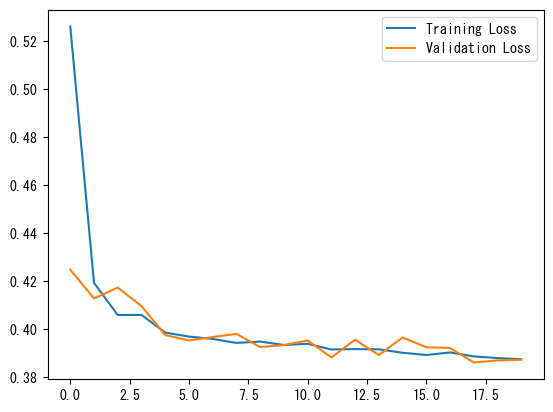

In [19]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [22]:
encoded_data = autoencoder.encoder(test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(test_data[10], 'b')
plt.plot(decoded_data[10], 'r')
plt.fill_between(np.arange(INPUT_SIZE), decoded_data[0], test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

AttributeError: Exception encountered when calling layer 'sequential_2' (type Sequential).

'tuple' object has no attribute 'rank'

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=      stroke_id  time     shape_str  pressure_avg  shape_int      len_mm  \
0             0     0      Straight    115.473684          1   80.054154   
1             1     2      Straight    106.814815          1  237.091119   
2             2     9  Simple curve    109.294118          2   41.309921   
3             3    11  Simple curve    118.181818          2   38.290272   
4             4    14  Simple curve     95.833333          2    5.867893   
...         ...   ...           ...           ...        ...         ...   
1983       1983  1237  Simple curve     78.142857          2  284.995283   
1984       1984  1238      Straight     71.272727          1  130.946774   
1985       1985  1238      Straight     70.888889          1   87.927395   
1986       1986  1238      Straight     84.666667          1  119.567617   
1987       1987  1239      Hatching     81.880000          4  445.417081   

                                                 ptx_mm  \
0     [103.16250000000002, 104.32499999999999, 105.2...   
1     [169.08750000000003, 168.82500000000005, 168.7...   
2     [169.20000000000005, 169.20000000000005, 169.1...   
3     [103.42500000000001, 103.53750000000002, 103.5...   
4     [102.41250000000004, 102.41250000000004, 102.4...   
...                                                 ...   
1983  [130.04999999999998, 150.9, 159.2625, 177.4874...   
1984  [108.4125, 111.1875, 121.725, 126.4875, 154.23...   
1985  [219.9375, 213.9375, 207.375, 192.9, 177.975, ...   
1986  [115.725, 113.1375, 111.5625, 111.0, 112.3125,...   
1987  [214.4625, 210.4125, 205.61249999999998, 188.2...   

                                                 pty_mm remove_index  \
0     [194.40000000000003, 194.70000000000002, 195.1...           []   
1     [237.9, 238.2375, 238.425, 238.425, 237.4875, ...           []   
2     [236.5875, 236.6625, 238.5, 239.9625, 241.125,...           []   
3     [194.32500000000002, 196.27500000000003, 197.4...           []   
4     [231.8625, 231.90000000000003, 232.20000000000...           []   
...                                                 ...          ...   
1983  [185.54999999999998, 193.575, 196.612499999999...           []   
1984  [181.0875, 181.98749999999998, 185.17499999999...           []   
1985  [214.95, 213.0, 210.86249999999998, 206.475, 2...           []   
1986  [183.7125, 183.075, 182.73749999999998, 182.66...           []   
1987  [215.85, 214.23749999999998, 212.5125, 206.7, ...           []   

                                    ptx_mm_slide_expand  ...  \
0     [0.0, 0.5175292153589292, 1.0350584307178583, ...  ...   
1     [0.9210526315789478, 0.59868421052633, 0.27631...  ...   
2     [4.203821656051186, 4.203821656051186, 4.20382...  ...   
3     [14.055118110235815, 14.081504439604295, 14.10...  ...   
4     [38.940397350995745, 38.940397350995745, 38.94...  ...   
...                                                 ...  ...   
1983  [70.66122032167473, 71.48923495872688, 72.3172...  ...   
1984  [0.0, 0.44457795133672273, 0.8891559026734933,...  ...   
1985  [420.00000000000006, 419.5572422517394, 419.11...  ...   
1986  [18.273480662983406, 17.79696132596684, 17.320...  ...   
1987  [364.16342412451365, 362.5291828793775, 360.89...  ...   

                                            140*140_img  \
0     [[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
1983  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0,...   
1984  [[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1985  [[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1986  [[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   
1987  [[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,...   

                                     140*140_img_vector drawing_id  year  \
0     [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          3  2013   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          3  2013   
2     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          3  2013   
3     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...          3  2013   
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...          3  2013   
...                                                 ...        ...   ...   
1983  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...        957  2022   
1984  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        957  2022   
1985  [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        957  2022   
1986  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...        957  2022   
1987  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...        957  2022   

      month  day  motif  times   name  \
0         4   18     紙箱      1  井原亜利紗   
1         4   18     紙箱      1  井原亜利紗   
2         4   18     紙箱      1  井原亜利紗   
3         4   18     紙箱      1  井原亜利紗   
4         4   18     紙箱      1  井原亜利紗   
...     ...  ...    ...    ...    ...   
1983      6   13     紙箱      3  saito   
1984      6   13     紙箱      3  saito   
1985      6   13     紙箱      3  saito   
1986      6   13     紙箱      3  saito   
1987      6   13     紙箱      3  saito   

                                                cos_sim  
0     [1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, ...  
1     [1.0, 0.9927337820337144, -0.5144957554275599,...  
2     [1.0, 0.9991680531005747, 0.9999999999999999, ...  
3     [1.0, 1.0000000000000002, 1.0, 1.0, 0.99999999...  
4     [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
...                                                 ...  
1983  [0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 0.999...  
1984  [0.9999999999999999, 1.0000000000000002, 1.0, ...  
1985  [1.0, 1.0, 1.0, 1.0, 0.9999999999999999, 0.999...  
1986  [1.0, 1.0, 1.0, 1.0000000000000002, 1.00000000...  
1987  [1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, ...  

[23535 rows x 22 columns]
  • training=None
  • mask=None